# Introduction

This notebook presents **bag-of-words** sentiment anlysis on [IMDB](http://ai.stanford.edu/~amaas/data/sentiment/) movie reviews dataset in Keras.

**Contents**

* [IMDB Dataset](#IMDB-Dataset) - load and preprocess
* [Keras Model](#Keras-Model) - build and train model

# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Limit TensorFlow GPU memory usage

In [2]:
import tensorflow as tf

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
with tf.Session(config=config):
    pass  # init sessin with allow_growth

# IMDB Dataset

Load IMDB movie review dataset using Keras API. Most params are set to default values.

In [3]:
(x_train_raw, y_train), (x_test_raw, y_test) = tf.keras.datasets.imdb.load_data(
    path='imbd.npz',  # download to '~/.keras/datasets/' + path
    num_words=10000,  # top most frequent words to consider
    skip_top=0,       # top most frequent words to ignore ('the', 'a', 'at', ...)
    maxlen=None,      # truncate reviews longer than this
    seed=113,         # data shuffling seed
    start_char=1,     # start-of-sequence token
    oov_char=2,       # if skip_top used, then dropped words replaced with this token
    index_from=3)     # actual word tokens start here

Data shapes

In [4]:
print(x_train_raw.shape)
print(x_test_raw.shape)

(25000,)
(25000,)


Example data sample

In [5]:
print('Label:', y_train[0])
print('Review:', x_train_raw[0])

Label: 1
Review: [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


As a sanity check recreate word dictionary

In [6]:
w2i = tf.keras.datasets.imdb.get_word_index()
w2i = {k:(v+2) for k,v in w2i.items()}  # 0 is <PAD>; add +2 for <ST> and <UNK>
w2i['<PAD>'] = 0
w2i['<ST>'] = 1
w2i['<UNK>'] = 2
i2w = {v: k for k, v in w2i.items()}

Print subset of vocabulary

In [7]:
vocab_10000 = [i2w[i] for i in range(10000)]  # 1000 most common words (indices are sorted)
print(sorted(vocab_10000)[:100])              # sort alphabeticaly and show first 100 words

["'", "'60s", "'70s", "'73", "'80s", "'a", "'cause", "'em", "'i", "'s", "'the", '0', '00', '000', '1', '10', '100', '1000', '101', '11', '12', '13', '13th', '14', '15', '150', '16', '17', '18', '18th', '19', '1920s', '1930', "1930's", '1930s', '1931', '1932', '1933', '1934', '1936', '1938', '1939', '1940', "1940's", '1940s', '1941', '1942', '1943', '1944', '1945', '1946', '1948', '1949', '1950', "1950's", '1950s', '1951', '1953', '1954', '1955', '1956', '1957', '1958', '1959', '1960', "1960's", '1960s', '1963', '1964', '1965', '1966', '1967', '1968', '1969', '1970', "1970's", '1970s', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980', "1980's", '1980s', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', "1990's"]


Print sample review as actual text

In [8]:
# 16965 is a "Bromwell High is a cartoon comedy..." review,
# which in original dataset is first train review
print(' '.join(i2w[id] for id in x_train_raw[16965] ))

<ST> <UNK> house br of party point i killers by and part she for there first frames it's getting plot something for devices would constructed old it and valley boy's humor well is course was <UNK> <UNK> survive br been drop is opening we br devices and <UNK> is context <UNK> and hangs ray so were their without should had magic <UNK> <UNK> and <UNK> to and bit dramatic at tongue well to and concepts this british a had ray very this almost and understand it only of fresh wes sorry is gotta want and getting this grade <UNK> by house of boring given horrific real these is flip all to end devices fresh cinderella is <UNK> house this thinking was being difference to would says characters was <UNK> house br making ape good of 0 was i saw


Convert movie reviews to multi-hot vectors of length 1000, where each position corresponds to one word in vocabulary

In [9]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=10000)
x_train = tokenizer.sequences_to_matrix(x_train_raw, mode='binary')
x_test = tokenizer.sequences_to_matrix(x_test_raw, mode='binary')
print('shape:', x_train.shape)
print('data:')
print(x_train[0, :100])

shape: (25000, 10000)
data:
[0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0.
 0. 1. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0.
 1. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 1. 0.]


# Keras Model

Simple multi-layer perceptron

In [10]:
from tensorflow.keras.layers import Dense
model = tf.keras.Sequential()
model.add(Dense(units=50, input_dim=10000, activation='sigmoid'))
model.add(Dense(units=1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                500050    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 500,101
Trainable params: 500,101
Non-trainable params: 0
_________________________________________________________________


Keras only logs metrics every epoch, to get more datapoints we implement our own callback.

In [11]:
class Callback(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.accs = []
    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.accs.append(logs.get('acc'))

Train model

In [12]:
cback = Callback()
history = model.fit(x=x_train, y=y_train, batch_size=250, epochs=2, callbacks=[cback])

Epoch 1/2
25000/25000 [==============================] - 2s 97us/step - loss: 0.4983 - acc: 0.7976
Epoch 2/2
25000/25000 [==============================] - 2s 76us/step - loss: 0.2991 - acc: 0.9028


Final results

In [13]:
loss, acc = model.evaluate(x_train, y_train, verbose=0)
print(f'Accuracy on train set: {acc:.2f}')
loss, acc = model.evaluate(x_test, y_test, verbose=0)
print(f'Accuracy on test set: {acc:.2f}')

Accuracy on train set: 0.93
Accuracy on test set: 0.89


Plot loss and accuracy during training period

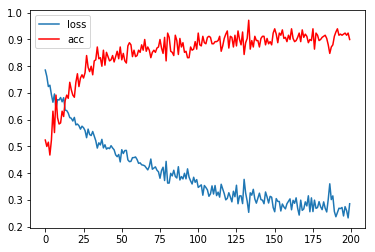

In [14]:
plt.plot(cback.losses, label='loss')
plt.plot(cback.accs, label='acc', color='red')
plt.legend();